# PaddlePaddle实现线性回归

欢迎大家来到这次实验！在本次实验中我们将使用PaddlePaddle来搭建一个简单的线性回归模型，并利用这一模型预测你的储蓄（在某地区）可以购买多大面积的房子。并且在学习模型搭建的过程中，了解到机器学习的若干重要概念，掌握一个机器学习预测的基本流程。

** 你将学会 **

- 机器学习基本概念：假设函数、损失函数、优化算法
- 数据归一化处理
- 搭建全连接神经网络，实现线性回归

在实验开始之前，我们先对机器学习的相关概念进行复习和回顾吧！

** 机器学习回顾 **

输入训练数据，利用特定的机器学习方法建立估计函数。得到函数后向这一模型输入测试数据，函数有能力对没有见过的数据进行正确估计，这就是机器学习的过程。
<img src="images/ML_process.png" style="width:300px;height:180px;">

** 线性回归的基本概念 **

线性回归是机器学习中最简单也是最重要的模型之一，其模型建立同样遵循上图流程：获取数据、数据预处理、训练模型、应用模型。

回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。

在线性回归中有几个基本的概念需要掌握：
- 假设函数（Hypothesis Function）
- 损失函数（Loss Function）
- 优化算法（Optimization Algorithm）

###### 假设函数：

假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。
在本次线性回顾模型中，我们的假设函数为 $ \hat{Y}= aX_1+b $ ，其中，$\hat{Y}$表示模型的预测结果（预测房价），用来和真实的Y区分。模型要学习的参数即：a,b。

###### 损失函数：

损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。

建立模型后，我们需要给模型一个优化目标，使得学到的参数能够让预测值$\hat{Y}$尽可能地接近真实值Y。输入任意一个数据样本的目标值$y_i$和模型给出的预测值$\hat{Y_i}$，损失函数输出一个非负的实值。这个实值通常用来反映模型误差的大小。

对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。
$$MSE=\frac{1}{n}\sum_{i=1}^{n}(\hat{Y_i}-Y_i)^2$$
即对于一个大小为n的测试集，MSE是n个数据预测结果误差平方的均值。

###### 优化算法：

在模型训练中优化算法也是至关重要的，它决定了一个模型的精度和运算速度。本章的线性回归实例中主要使用了梯度下降法进行优化。

**梯度下降**是深度学习中非常重要的概念，值得庆幸的是它也十分容易理解。损失函数$J(w,b)$可以理解为变量$w$和$b$的函数。观察下图，垂直轴表示损失函数的值，两个水平轴分别表示变量$w$和$b$。实际上，可能是更高维的向量，但是为了方便说明，在这里假设$w$和$b$都是一个实数。算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量$w$和$b$的值，一步一步地试出这个最小值。而试的方法就是沿着梯度方向逐步移动。本例中让图中的圆点表示损失函数的某个值，那么梯度下降就是让圆点沿着曲面下降，直到取到最小值或逼近最小值。

因为是凸函数，所以无论初始化在曲面上的哪一点，最终都会收敛到同一点或者相近的点。

<img src="images/gradient_descent.png" style="width:380px;height:180px;">


现在，让我们正式进入实验吧！

# 1 - 引用库

首先载入需要用到的库，它们分别是：

- numpy：一个python的基本库，用于科学计算
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- paddle.fluid：PaddlePaddle其中一种深度学习框架
- pandas:一种基于NumPy的工具，高效处理数据

In [1]:
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# 2 - 数据预处理

本次数据集使用的是2016年12月份某市某地区的房价分布。为了简化模型，假设影响房价的因素只有房屋面积，因此数据集只有两列，以TXT的形式储存。

当真实数据被收集到后，它们往往不能直接使用。例如本次数据集使用了某地区的房价分布，为了简化模型数据只有两维，分别是房屋面积与房屋价格。可以看到房价与房屋面积之间存在一种关系，这种关系究竟是什么，就是本次预测想要得到的结论。可以首先以表格的形式输出数据的前五行看一下

In [2]:
colnames = ['房屋面积']+['房价']
print_data = pd.read_csv('./datasets/data.txt',names = colnames)
print_data.head()

房屋面积     房价
0   98.87  599.0
1   68.74  450.0
2   89.24  440.0
3  129.19  780.0
4   61.64  450.0

一般拿到一组数据后，第一个要处理的是数据类型不同的问题。如果各维属性中有离散值和连续值，就必须对离散值进行处理。

离散值虽然也常使用类似0、1、2这样的数字表示，但是其含义与连续值是不同的，因为这里的差值没有实际意义。例如，我们用0、1、2来分别表示红色、绿色和蓝色的话，我们并不能因此说“蓝色和红色”比“绿色和红色”的距离更远。通常对有d个可能取值的离散属性，我们会将它们转为d个取值为0或1的二值属性或者将每个可能取值映射为一个多维向量。

不过就这里而言，数据中没有离散值，就不用考虑这个问题了。

** 归一化 **

观察一下数据的分布特征，一般而言，如果样本有多个属性，那么各维属性的取值范围差异会很大，这就要用到一个常见的操作-归一化（normalization）了。归一化的目标是把各维属性的取值范围放缩到差不多的区间，例如[-0.5, 0.5]。这里我们使用一种很常见的操作方法：减掉均值，然后除以原取值范围。

虽然本次房价预测模型中，输入属性只有房屋面积，不存在取值范围差异问题，但由于归一化的各种优点，我们仍选择对其进行归一化操作。

** 练习 **

完成下列代码，实现房屋面积的归一化。

输出归一化后的房价最大值，判断操作是否正确。

In [3]:
# coding = utf-8 #
global x_raw,train_data,test_data
data = np.loadtxt('./datasets/data.txt',delimiter = ',')
x_raw = data.T[0].copy() 

#axis=0,表示按列计算
#data.shape[0]表示data中一共有多少列
maximums, minimums, avgs = data.max(axis=0), data.min(axis=0), data.sum(axis=0)/data.shape[0]
print "the raw area :",data[:,0].max(axis = 0)

#归一化，data[:,i]表示第i列的元素

### START CODE HERE ### (≈ 3 lines of code)
feature_num = 2
for i in xrange(feature_num-1):
    data[:,i] = (data[:,i]-avgs[i])/(maximums[i]-minimums[i])
### END CODE HERE ###

print 'normalization:',data[:,0].max(axis = 0)
    

the raw area : 199.96
normalization: 0.6587568635148239


期望输出：normalization: 0.658756863515

基本上所有的数据在拿到后都必须进行归一化，至少有以下3条原因：

1.过大或过小的数值范围会导致计算时的浮点上溢或下溢。

2.不同的数值范围会导致不同属性对模型的重要性不同（至少在训练的初始阶段如此），而这个隐含的假设常常是不合理的。这会对优化的过程造成困难，使训练时间大大加长。

3.很多的机器学习技巧/模型（例如L1，L2正则项，向量空间模型-Vector Space Model）都基于这样的假设：所有的属性取值都差不多是以0为均值且取值范围相近的。

** 数据集分割 **

将原始数据处理为可用数据后，为了评估模型的好坏，我们将数据分成两份：训练集和测试集。
- 训练集数据用于调整模型的参数，即进行模型的训练，模型在这份数据集上的误差被称为训练误差；
- 测试集数据被用来测试，模型在这份数据集上的误差被称为测试误差。

我们训练模型的目的是为了通过从训练数据中找到规律来预测未知的新数据，所以测试误差是更能反映模型表现的指标。分割数据的比例要考虑到两个因素：更多的训练数据会降低参数估计的方差，从而得到更可信的模型；而更多的测试数据会降低测试误差的方差，从而得到更可信的测试误差。我们这个例子中设置的分割比例为8:2。

** 练习 **

补全下列代码，完成训练集与测试集的分割。输出数据大小，验证分割是否正确。

- 提示：

    A[:x] 表示取A中的前x个元素
    
    A[x:]表示从第x+1个元素开始取到最后一个元素

In [4]:
ratio = 0.8
offset = int(data.shape[0]*ratio)

### START CODE HERE ### (≈ 2 lines of code)
train_data = data[:offset].copy()
test_data = data[offset:].copy()
### END CODE HERE ###

print(len(data))
print(len(train_data))

870
696


期望输出：  
870  
696  

# 3 - 定义reader

构造read_data()函数，来读取训练数据集train_set或者测试数据集test_set。它的具体实现是在read_data()函数内部构造一个reader()，使用yield关键字来让reader()成为一个Generator（生成器），注意，yield关键字的作用和使用方法类似return关键字，不同之处在于yield关键字可以构造生成器（Generator）。虽然我们可以直接创建一个包含所有数据的列表，但是由于内存限制，我们不可能创建一个无限大的或者巨大的列表，并且很多时候在创建了一个百万数量级别的列表之后，我们却只需要用到开头的几个或几十个数据，这样造成了极大的浪费，而生成器的工作方式是在每次循环时计算下一个值，不断推算出后续的元素，不会创建完整的数据集列表，从而节约了内存使用。

In [5]:
def read_data(data_set):
    """
    一个reader
    Args：
        data_set -- 要获取的数据集
    Return：
        reader -- 用于获取训练集及其标签的生成器generator
    """
    def reader():
        """
        一个reader
        Args：
        Return：
            data[:-1],data[-1:] --使用yield返回生成器
                data[:-1]表示前n-1个元素，也就是训练数据，
                data[-1:]表示最后一个元素，也就是对应的标签
        """
        for data in data_set:
            yield data[:-1],data[-1:]
    return reader

获取训练数据集和测试数据集

In [6]:
def train():
    """
    定义一个reader来获取训练数据集及其标签
    Args：
    Return：
        read_data -- 用于获取训练数据集及其标签的reader
    """
    global train_data
    return read_data(train_data)

def test():
    global test_data
    return read_data(test_data)

测试reader：

In [7]:
test_array = ([10,100],[20,200])
print("test_array for read_data:")
for value in read_data(test_array)():
    print(value)

test_array for read_data:
([10], [100])
([20], [200])


# 4 - 训练过程


完成了数据的预处理工作并构造了read_data()来读取数据，接下来将进入模型的训练过程，使用PaddlePaddle来定义构造可训练的线性回归模型，关键步骤如下：

- 初始化

- 配置网络结构和设置参数
    - 配置网络结构
    - 定义损失函数cost
    - 定义program
    - 定义优化器optimizer

- 模型训练

- 预测

- 绘制拟合图像

** （1）定义运算场所 **

首先进行最基本的运算场所定义，在 fluid 中使用 place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace() 来进行初始化：

- place 表示fluid program的执行设备，常见的有 fluid.CUDAPlace(0) 和 fluid.CPUPlace()
- use_cuda = False 表示不使用 GPU 进行加速训练

In [25]:
#使用CPU训练
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

** （2）配置网络结构和设置参数 **

** 配置网络结构 **


线性回归的模型其实就是一个采用线性激活函数（linear activation）的全连接层（fully-connected layer，fc_layer），因此在Peddlepeddle中利用全连接层模型构造线性回归，这样一个全连接层就可以看做是一个简单的神经网络，只包含输入层和输出层即可。本次的模型由于只有一个影响参数，因此输入只含一个$X_0$。

<img src="images/FC.png" style="width:380px;height:180px;">

接下来就让我们利用PaddlePaddle提供的接口，搭建我们自己的网络吧！

** 输入层 **

我们可以用x = fluid.layers.data(name='x', shape=[1], dtype='float32')来表示数据的一个输入层，其中名称为"x"，数据类型为一维向量。

** 输出层 **

用y_predict = fluid.layers.fc(input=x, size=1, act=None)来表示输出层：其中paddle.layer.fc表示全连接层，input=x表示该层出入数据为x，size=1表示该层有一个神经元，act=None表示激活函数为线性激活函数。


** 标签层 **

用y = fluid.layers.data(name='y', shape=[1], dtype='float32')来表示标签数据，名称为y，数据类型为一维向量

** 练习 ** 完成下面代码

In [9]:
# 输入层，fluid.layers.data表示数据层,name=’x’：名称为x,输出类型为tensor
# shape=[1]:数据为1维向量
# dtype='float32'：数据类型为float32

### START CODE HERE ### (≈ 1 lines of code)
x = fluid.layers.data(name='x', shape=[1], dtype='float32')
### END CODE HERE ###


# 标签数据，fluid.layers.data表示数据层,name=’y’：名称为y,输出类型为tensor
# shape=[1]:数据为1维向量

### START CODE HERE ### (≈ 1 lines of code)
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
### END CODE HERE ###


# 输出层，fluid.layers.fc表示全连接层，input=x: 该层输入数据为x
# size=1：神经元个数，act=None：激活函数为线性函数

### START CODE HERE ### (≈ 1 lines of code)
y_predict = fluid.layers.fc(input=x, size=1, act=None)
### END CODE HERE ###


** 定义损失函数 **

本次使用的是均方差损失函数，可以调用fluid.layers.square_error_cost(input= ,laybel= )实现方差计算，通过fluid.layers.mean(loss)对方差求平均。  
将输入定义为 **房价预测值**，label定义为 **标签数据**。进而计算损失值。

** 练习 ** 完成下面代码


In [10]:
# 定义成本函数为均方差损失函数

### START CODE HERE ### (≈ 2 lines of code)
loss = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_loss = fluid.layers.mean(loss)
### END CODE HERE ###

** 封装训练参数 **

将设计完成的网络参数写入 train_program() 函数，便于训练时调用

In [11]:
def train_program():
    ### START CODE HERE ### (≈ 5 lines of code)
    y = fluid.layers.data(name='y', shape=[1], dtype='float32')

    # feature vector of length 1
    x = fluid.layers.data(name='x', shape=[1], dtype='float32')
    y_predict = fluid.layers.fc(input=x, size=1, act=None)

    loss = fluid.layers.square_error_cost(input=y_predict, label=y)
    avg_loss = fluid.layers.mean(loss)
    ### END CODE HERE ###

    return avg_loss

** 优化方法 **

损失函数定义确定后，需要定义参数优化方法。为了改善模型的训练速度以及效果，学术界先后提出了很多优化算法，包括： Momentum、RMSProp、Adam 等，已经被封装在fluid内部，读者可直接调用。本次可以用 fluid.optimizer.SGD(learning_rate= ) 使用随机梯度下降的方法优化，其中learning_rate可自己尝试修改。

** 练习 **

请自行设置学习率的值，观察cost函数的变化。

- 学习率参数为：learning_rate

In [12]:
# 创建optimizer，更多优化算子可以参考 fluid.optimizer()
def optimizer_program():
    learning_rate = 0.001
    ### START CODE HERE ### (≈ 1 lines of code)
    return fluid.optimizer.SGD(learning_rate= learning_rate)
    ### END CODE HERE ###


** 其它配置 **

feed_order=['x', 'y'] 是数据层名称和数组索引的映射，用于定义数据的读取顺序。  
params_dirname用于定义模型保存路径。

最后定义事件处理器 event_handler_plot(event) 用于打印训练过程，在 fulid 中有两种形式的事件处理器，分别是文字形式与图像形式。本次使用的是图像形式的处理器，当训练开始时调用该函数，可以得到 loss 变化图像，便于使用者进行参数调整。

In [ ]:
# 数据层和数组索引映射，用于trainer训练时喂数据
feed_order = ['x', 'y']
# 保存模型
params_dirname = "easy_fit_a_line.inference.model"

In [13]:
# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0

# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 10 == 0:
            plot_cost.append(train_title, step, event.metrics[0])
            plot_cost.plot()
        if event.step % 100 == 0: # 每10个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)

            plot_cost.append(test_title, step, test_metrics[0])
            plot_cost.plot()

            if test_metrics[0] < 10.0:
                # 如果准确率达到阈值，则停止训练
                print('loss is less than 10.0, stop')
                trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)

    step += 1

** （3）训练模型 **

上述内容进行了模型初始化、网络结构的配置并创建了训练函数、硬件位置、优化方法，接下来利用上述配置进行模型训练。


首先定义执行器，fulid使用了一个C++类Executor用于运行一个程序，Executor类似一个解释器，Fluid将会使用这样一个解析器来训练和测试模型。
一个随机梯度下降trainer，配置三个参数cost、parameters、update_equation，它们分别表示损失函数、参数和更新公式。

再利用 trainer.train() 即可开始真正的模型训练，我们可以设置参数如下：

** 定义执行器(参数随机初始化) **

用户配置完模型后，参数初始化操作会被写入到 fluid.default_startup_program() 中。使用 fluid.Executor() 运行 这一程序，即可在全局 fluid.global_scope() 中随机初始化参数。

In [14]:
# 创建执行器，palce在程序初始化时设定
exe = fluid.Executor(place)
# 初始化执行器
exe.run( fluid.default_startup_program() )

[]

** 设置训练参数 **

同学们可以试着调整一下参数值，看会有什么变化。

关于参数的解释如下：

- paddle.reader.shuffle(train(), buf_size=500)表示trainer从train()这个reader中读取了buf_size=500大小的数据并打乱顺序
- paddle.batch(reader(), batch_size=BATCH_SIZE)表示从打乱的数据中再取出BATCH_SIZE=20大小的数据进行一次迭代训练

In [15]:
BATCH_SIZE = 20

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        train(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        test(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

** 创建训练器 **

训练器创建训练器时需要提供3个主要信息：
1. 一个配置好的网络拓扑结构
2. 训练的硬件场所
3. 具体的优化方法

In [16]:
trainer = fluid.Trainer(
    train_func= train_program,
    place= place,
    optimizer_func= optimizer_program)

用户可以打印出自己设置的网络参数，以查看网络结构是否符合期待。

In [36]:
# print(fluid.default_main_program().to_string(True))

** 开始训练 **

我们现在可以通过调用trainer.train()来开始训练了，通过观察损失函数图像看看自己的模型是不是完美了呢！

尝试调整 num_epochs 观察损失函数的变化吧（可以先尝试100）

关于参数的解释如下：

- 参数feed_order用到了之前定义的feed_order索引，将数据层x和y按顺序输入trainer，也就是数据的来源。
- 参数event_handler是事件管理机制，读者可以自定义event_handler，根据事件信息作相应的操作。
- 参数num_epochs=100表示迭代训练100次后停止训练。

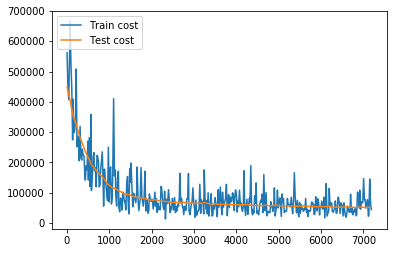

<Figure size 432x288 with 0 Axes>

In [18]:
trainer.train(
    reader=train_reader,
    ### START CODE HERE ### (≈ 1 lines of code)
    num_epochs=100,
    ### END CODE HERE ###
    event_handler=event_handler_plot,
    feed_order=feed_order)

得到的cost函数变化图像大致应是一个收敛的结果：
<img src='images/result.png' style = "width:400px;height:300px;">

# 4 - 预测

**（1）设定预测程序 **

类似于 trainer.train，预测器需要一个预测程序来做预测。我们可以稍加修改我们的训练程序来把预测值包含进来。

In [19]:
# 设置预测程序
def inference_program():
    x = fluid.layers.data(name='x', shape=[1], dtype='float32')
    y_predict = fluid.layers.fc(input=x, size=1, act=None)
    return y_predict

**（2）预测 **

预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

- tensor_x:生成b atch_size个[0,1]区间的随机数，以 tensor 的格式储存
- results：预测对应 tensor_x 面积的房价结果
- raw_x:由于数据处理时我们做了归一化操作，为了更直观的判断预测是否准确，将数据进行反归一化，得到随机数对应的原始数据。

In [34]:
inferencer = fluid.Inferencer(
    infer_func=inference_program, param_path=params_dirname, place=place)

batch_size = 2
tensor_x = np.random.uniform(0, 1, [batch_size, 1]).astype("float32")

results = inferencer.infer({'x': tensor_x})
raw_x = tensor_x*(maximums[i]-minimums[i])+avgs[i]
print("the area is:",raw_x)
print("infer results: ", results[0])

('the area is:', array([[118.86281],
       [100.88023]], dtype=float32))
('infer results: ', array([[773.4026],
       [652.7006]], dtype=float32))


此处应得到一组预测结果：

('the area is:', array([[####],

       [####]], dtype=float32))
       
('infer results: ', array([[####],

       [####]], dtype=float32))


** 练习 **

根据线性模型的原理，补全输出公式，计算a和b的值

    - 提示：已知两点求直线方程


In [21]:
### START CODE HERE ### (≈ 2 lines of code)
a = (results[0][0][0] - results[0][1][0]) / (raw_x[0][0]-raw_x[1][0])
b = (results[0][0][0] - a * raw_x[0][0])
### END CODE HERE ###
print(a,b)

(6.712159, -24.423462)


预测结果应为：a=6.7,b=-24.42(每次训练结果取随机数，因此得到的结果可能会有一点点偏差，但大致应在这个范围之间）,因此本次模型得到的房屋面积与房价之间的拟合函数为$y=6.7x-24.42$。其中y为预测的房屋价格，x为房屋面积，根据这个公式可以推断：如果有500万的预算，想在该地区购房，房屋面积大概为$\frac{500-(-24.42)}{6.7}=78(m^2)$。

** （5）绘制拟合图像  **

通过训练，本次线性回归模型输出了一条拟合的直线，想要直观的判断模型好坏可将拟合直线与数据的图像绘制出来。

**练习**

补全下列代码，绘制出你的预测图像（a和b的值应是你经过网络训练出来的结果）。

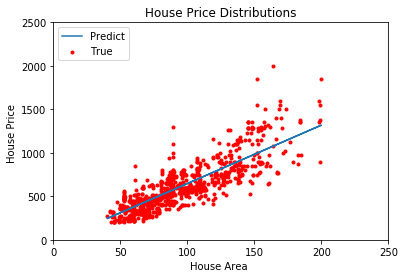

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(data):
    x = data[:,0]
    y = data[:,1]
    y_predict = x*a + b
    plt.scatter(x,y,marker='.',c='r',label='True')
    plt.title('House Price Distributions')
    plt.xlabel('House Area ')
    plt.ylabel('House Price ')
    plt.xlim(0,250)
    plt.ylim(0,2500)
    predict = plt.plot(x,y_predict,label='Predict')
    plt.legend(loc='upper left')
    plt.savefig('result1.png')
    plt.show()

### START CODE HERE ### (≈ 2 lines of code)    
data = np.loadtxt('./datasets/data.txt',delimiter = ',')
plot_data(data)
### START CODE HERE ### (≈ 2 lines of code)

从输出结果图可以看出，预测数据落在直线上，通过观察可以清楚地看到真实数据大部分散布在预测数据周围，说明预测结果是比较可靠的。

你得到的预测图，应与下图相似：<img src='images/plt.png' style = "width:400px;height:300px;">

# 5 - 总结

通过这个练习我们应该记住：

1. 机器学习的典型过程：
    
    - 获取数据
    
    - 数据预处理
    
    -训练模型
    
    -应用模型

2. fluid训练模型的基本步骤: 

    - 配置网络结构：
    
    - 定义成本函数avg_cost
    
    - 定义优化器optimizer
    
    - 获取训练数据
    
    - 定义运算场所(place)和执行器(exe)
    
    - 提供数据(feeder)

    - 执行训练(exe.run)

    - 预测infer()并输出拟合图像

3. 练习中的许多参数可以作调整，例如修改学习率会对模型结果产生很大影响，大家可以在本练习或者后面的练习中多做些尝试。


至此线性回归模型的训练工作完成，希望通过本次课程的学习，读者可以利用提供的代码完成一个简单的房价预测模型。通过这一过程，初步了解PaddlePaddle这一易学易用的分布式平台。

本节课作为PaddlePaddle的快速入门章节，希望可以开启您的下一步深度学习之门。

In [ ]:
inferencer = fluid.Inferencer(
    infer_func=inference_program, 
    param_path=params_dirname, 
    place=place)
